# Predator-Prey model with triangular transport map
Based on "Transport map accelerated Markov chain Monte Carlo" by Parno and Marzouk (SIAM/ASA Journal on Uncertainty Quantification 2018)

In [1]:
# %env JAX_DEBUG_NANS=True
import jax
import jax.numpy as np
import numpy as onp
import numpyro
from numpyro.contrib.autoguide import AutoDelta
from numpyro import distributions as dist
from numpyro.distributions import constraints
from numpyro.examples.runge_kutta import runge_kutta_4
from numpyro.infer import init_to_median, init_with_noise
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import OrderedDict

In [2]:
rng_key = jax.random.PRNGKey(242)

## Predator Prey Model

In [3]:
def predator_prey_step(t, state, r=0.6, k=100, s=1.2, a=25, u=0.5, v=0.3):
    prey = state[..., 0]
    predator = state[..., 1]
    sh = (prey * predator)/(a + prey + 1e-3)
    prey_upd = r * prey * (1 - prey / (k + 1e-3)) - s * sh
    predator_upd = u * sh - v * predator
    return np.stack((prey_upd, predator_upd), axis=-1)
num_time = 5
step_size = 0.1
num_steps = int(num_time / step_size)
dampening_rate = 0.8
lyapunov_scale = 1e-3
clip = lambda x: np.clip(x, -10.0, 10.0)
predator_prey = runge_kutta_4(predator_prey_step, step_size, num_steps, dampening_rate, 
                              lyapunov_scale, clip, unconstrain_fn=lambda _, x: x,
                              constrain_fn=lambda _, x: x)
predator_prey = jax.partial(predator_prey, rng_key)

In [4]:
indices = np.array([1, 11, 21, 31, 41])
res, lyapunov_loss = predator_prey(np.array([50., 5.]))
noise = jax.random.normal(rng_key, (1000,5,2)) * 10
data = (indices, res[indices] + noise)
data

(DeviceArray([ 1, 11, 21, 31, 41], dtype=int32),
 DeviceArray([[[ 39.024734 , -12.725596 ],
               [ 66.321266 ,   6.9570694],
               [ 68.02709  ,   3.5552971],
               [ 91.41242  ,  12.742345 ],
               [ 72.7559   ,  -2.7840161]],
 
              [[ 70.52719  ,   8.503682 ],
               [ 82.815735 ,   7.1307344],
               [ 47.493027 ,  -3.0287352],
               [ 79.04639  ,  12.486196 ],
               [ 61.74772  ,   7.4273853]],
 
              [[ 44.77134  ,  -8.647642 ],
               [ 68.059166 ,  10.351532 ],
               [ 62.732346 ,  20.398567 ],
               [ 76.33949  ,  24.198376 ],
               [ 68.472824 ,  11.550084 ]],
 
              ...,
 
              [[ 65.18128  ,  17.313398 ],
               [ 62.665043 ,   5.9123344],
               [ 77.014946 ,   7.073232 ],
               [ 80.4568   ,  16.428682 ],
               [ 73.003334 ,   4.452607 ]],
 
              [[ 60.071377 ,  -6.5541363],
               

In [5]:
def model(indices, observations):
    prior_dist = dist.HalfNormal(100)
    prey0 = numpyro.sample('prey0', prior_dist)
    predator0 = numpyro.sample('predator0', prior_dist)
    r = numpyro.sample('r', prior_dist)
    k = numpyro.sample('k', prior_dist)
    s = numpyro.sample('s', prior_dist)
    a = numpyro.sample('a', prior_dist)
    u = numpyro.sample('u', prior_dist)
    v = numpyro.sample('v', prior_dist)
    ppres, lyapunov_loss = predator_prey(np.array([prey0, predator0]), r=r, k=k, s=s, a=a, u=u, v=v)
    numpyro.factor('lyapunov_loss', lyapunov_loss)
    numpyro.sample('obs', dist.Normal(ppres[indices], 10.0).to_event(2), obs=observations)

### Guide and Stein with Transport Maps

In [6]:
svgd = numpyro.infer.SVGD(model, AutoDelta(model, init_strategy=init_to_median()), 
                          numpyro.optim.Adam(0.01), numpyro.infer.ELBO(),
                          numpyro.infer.kernels.RBFKernel(), num_particles=100,
                          repulsion_temperature=0.001 * data[1].shape[0])
state, loss = svgd.run(rng_key, 10000, *data)  # rounds 10000

SVGD 2.1665e+05: 100%|██████████| 10000/10000 [02:10<00:00, 76.86it/s]


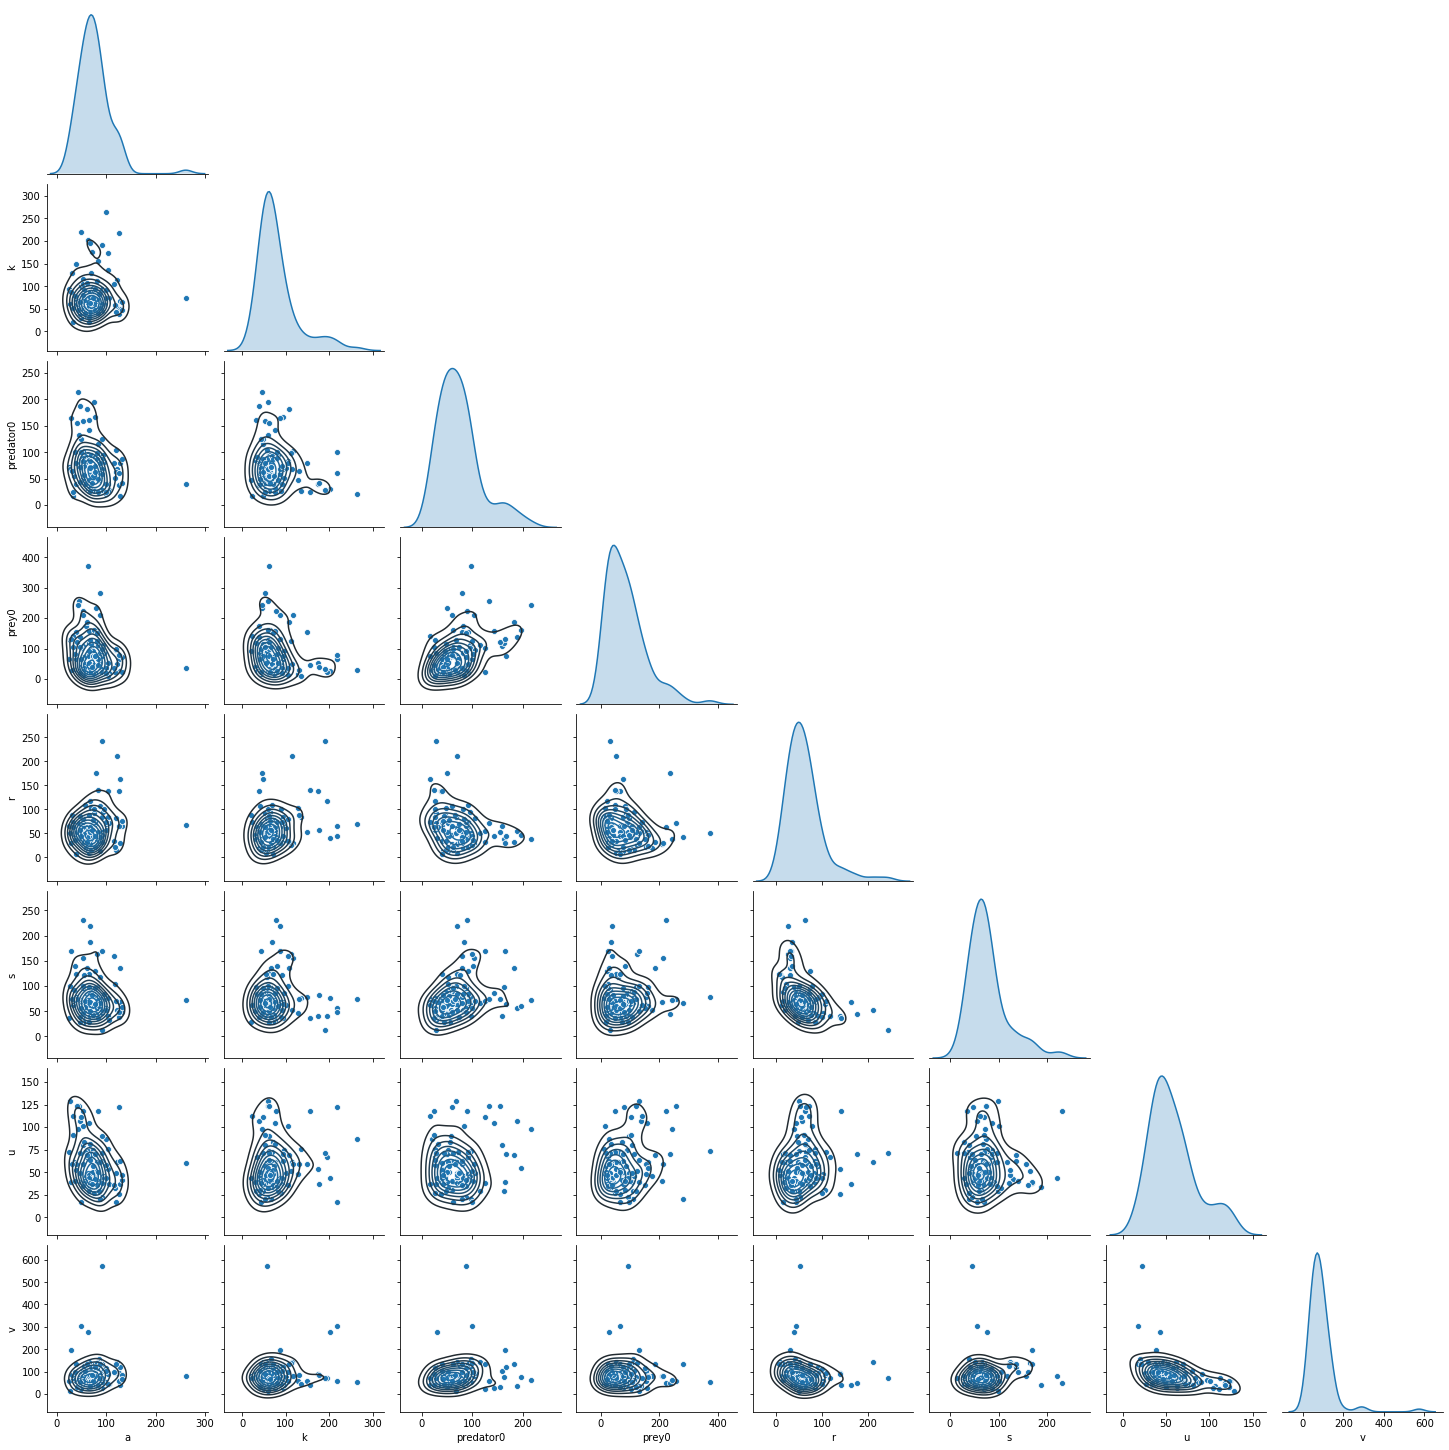

In [7]:
sample_frame = pd.DataFrame.from_dict(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

In [8]:
def transmap_guide(indices, observations):
    param_keys = {'prey0', 'preadtor0', 'r', 'k', 's', 'a', 'u', 'v'}
    params = OrderedDict()
    for k in param_keys:
        params[k] = numpyro.param(f'{k}$val', 25.)
    tmapp = numpyro.param('tmapp', np.zeros(8 * (8 + 1) // 2))
    tril_idx = np.tril_indices(8)
    tmap = jax.ops.index_update(np.zeros((8, 8)), tril_idx, tmapp)
    tloc = numpyro.param('tloc', np.zeros(8))
    tvals = jax.nn.softplus(tmap @ np.array(list(params.values())) + tloc)
    for pk, tval in zip(params.keys(), tvals):
        if pk == 'k':
            tval = tval
        numpyro.sample(pk, dist.Delta(tval))

In [9]:
svgd = numpyro.infer.SVGD(model, numpyro.guides.WrappedGuide(transmap_guide, init_strategy=init_with_noise(init_to_median())), 
                          numpyro.optim.Adam(0.01), numpyro.infer.ELBO(),
                          numpyro.infer.kernels.RBFKernel(), repulsion_temperature=0.01 * data[1].shape[0],
                          num_particles=100,
                          classic_guide_params_fn=lambda n: n in {'tmapp', 'tloc'})
state, loss = svgd.run(rng_key, 10000, *data)

SVGD 1.2422e+05: 100%|██████████| 10000/10000 [04:33<00:00, 36.54it/s]


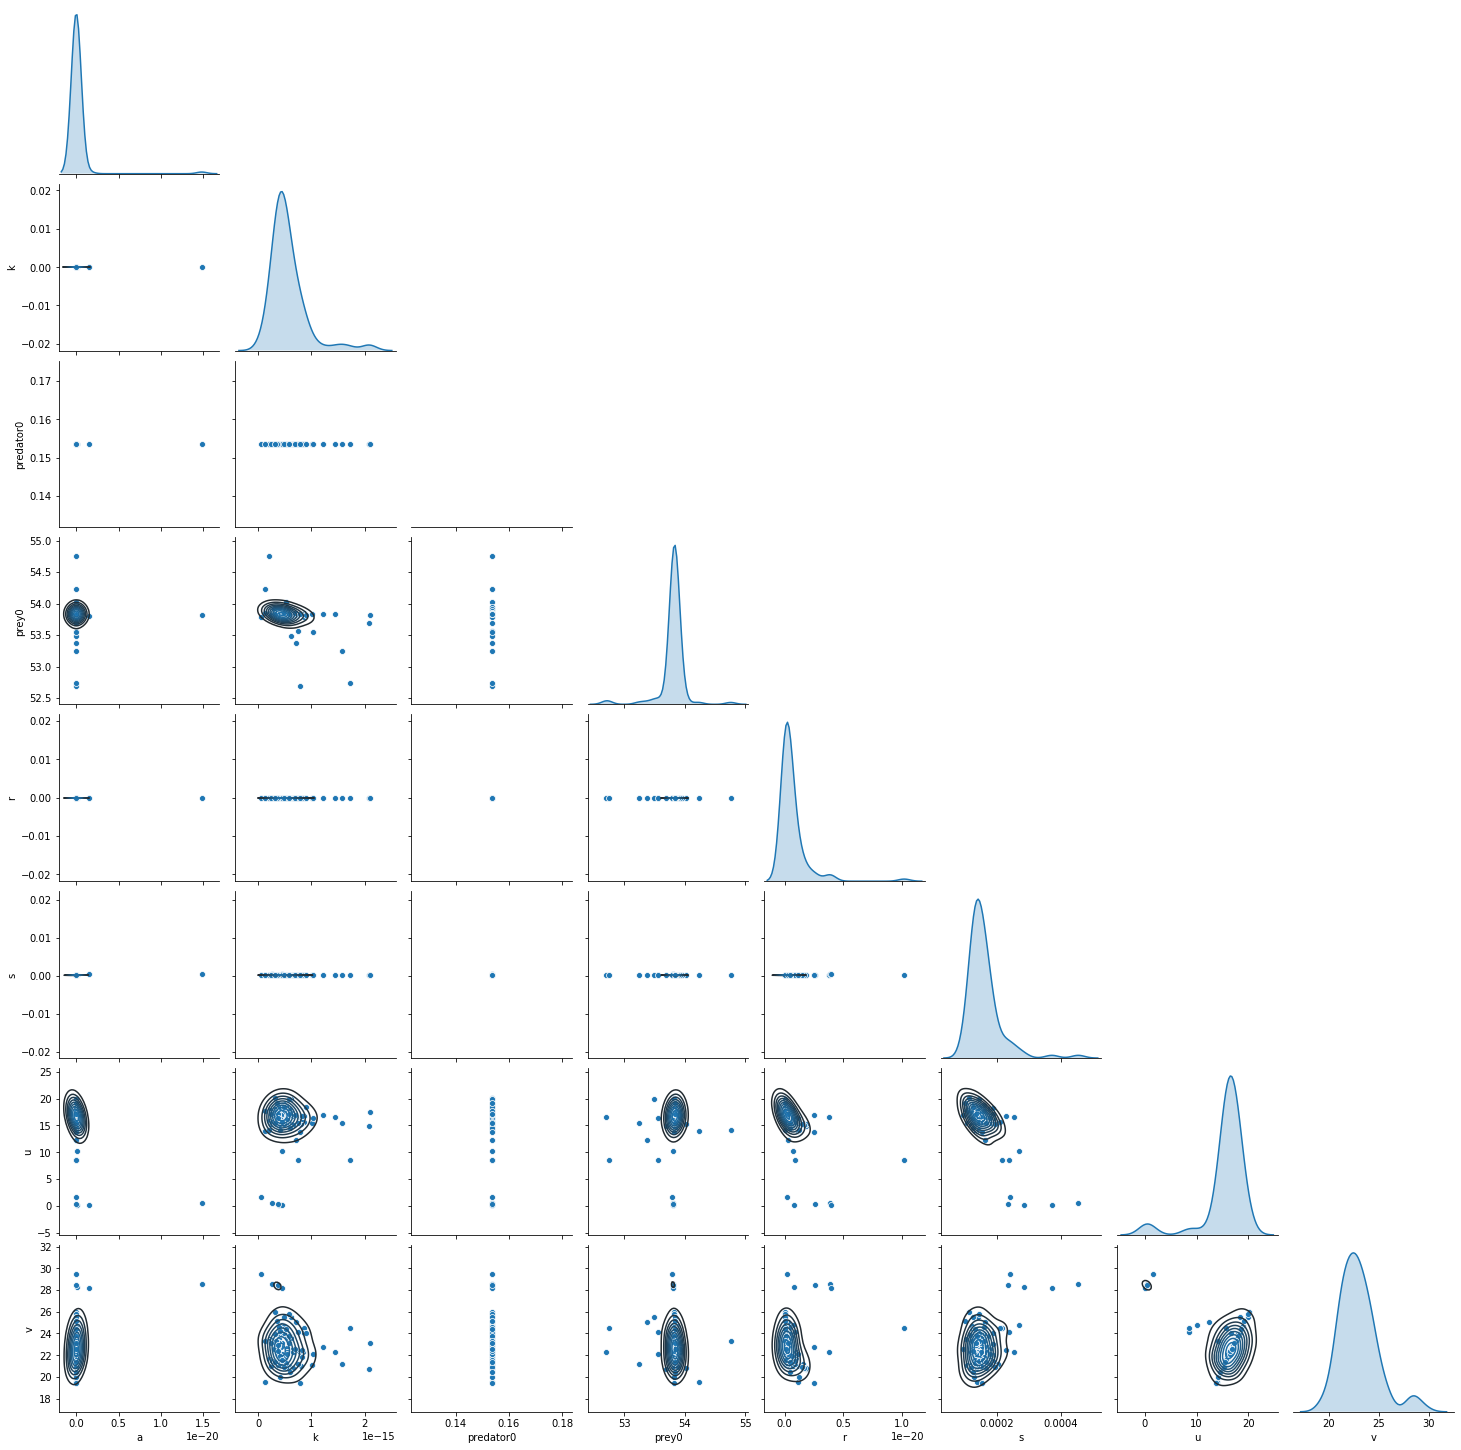

In [10]:
sample_frame = pd.DataFrame(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

### NUTS MCMC Sampling

In [11]:
mcmc = numpyro.infer.MCMC(numpyro.infer.NUTS(model), 100, 500, chain_method='vectorized')
mcmc.run(rng_key, *data)
mcmc.print_summary()

sample: 100%|██████████| 600/600 [00:47<00:00, 12.50it/s, 1023 steps of size 6.77e-04. acc. prob=0.87]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.18      0.00      0.18      0.18      0.19      7.97      1.13
          k     72.80      0.35     72.73     72.42     73.13     21.88      1.03
  predator0      0.36      0.01      0.36      0.34      0.38      3.58      1.83
      prey0     31.14      6.95     33.02     32.17     33.89     14.16      1.07
          r      6.00      0.18      6.01      5.88      6.25     10.36      1.03
          s      1.29      0.09      1.32      1.14      1.41      2.52      2.48
          u      0.49      0.02      0.49      0.47      0.52      4.62      1.00
          v      0.87      0.02      0.88      0.84      0.90      4.42      1.23

Number of divergences: 0


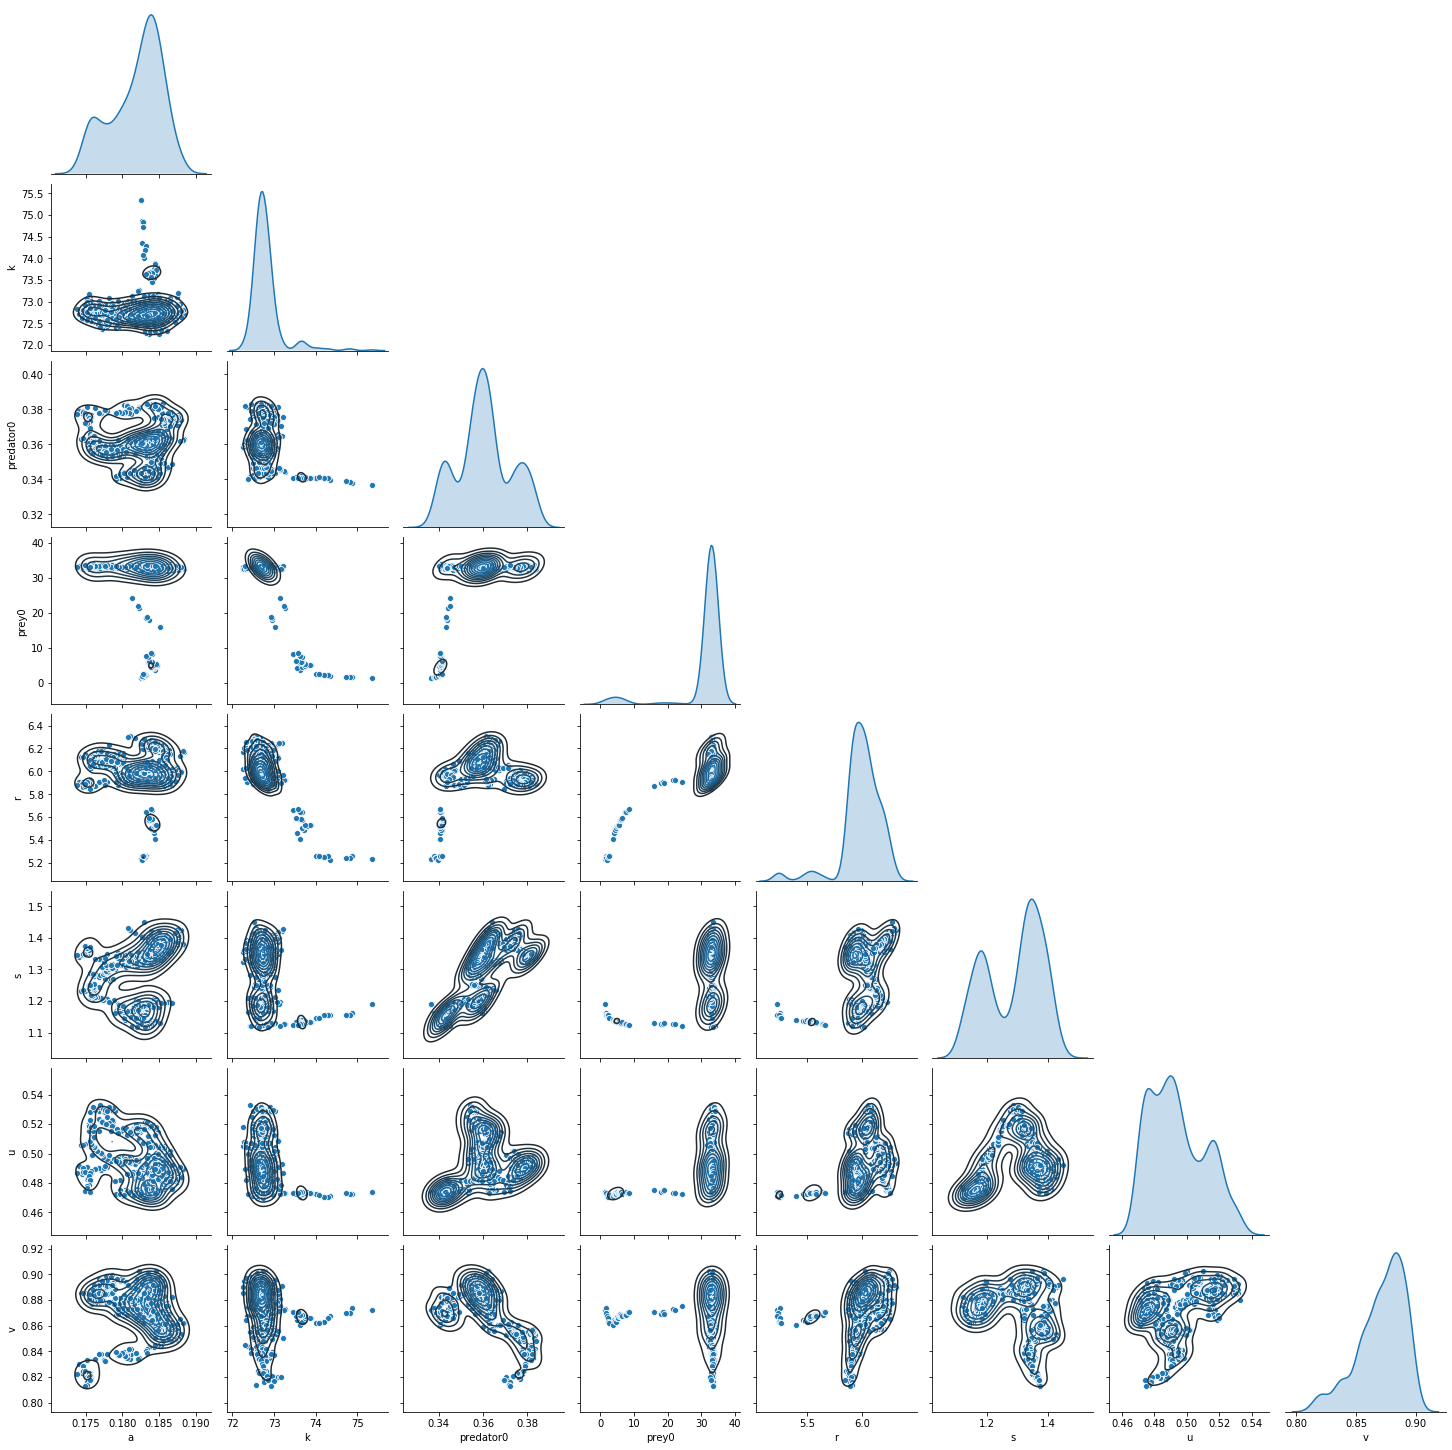

In [12]:
samples = mcmc.get_samples()
sample_frame = pd.DataFrame(samples)
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)